# Download Data

In [1]:
!wget -q https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/EfREjZqiZTlPqhqUPICBbPABdlgPumlaUVxPncm-_9aWIw?download=1 -O "Project 1 - data.zip"
!unzip -q "Project 1 - data.zip"

# Import Libraries

In [2]:
!pip -q install transformers

     |████████████████████████████████| 2.0MB 10.9MB/s 
     |████████████████████████████████| 870kB 35.9MB/s 
     |████████████████████████████████| 3.2MB 35.2MB/s 


In [3]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout,\
    Activation, Input, Add, Concatenate, Embedding, Conv1D, MaxPool1D,\
    Flatten, LSTM, Bidirectional, MaxPooling1D, SimpleRNN, GRU, SpatialDropout1D
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from google.colab import files
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# Data Loader

In [4]:
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

In [5]:
train_df = load_data('train', columns=['full'])
valid_df = load_data('valid', columns=['full'])
test_df = load_data('test', columns=['full'])

select [full] columns from the train split
Failed, then try to 
select all columns from the train split
select [full] columns from the valid split
Failed, then try to 
select all columns from the valid split
select [full] columns from the test split
Failed, then try to 
select all columns from the test split


# Load BERT tokenizer

In [6]:
model_name = 'bert-base-uncased'
max_length = 100
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Prepare the data using BERT Tokenizer

In [7]:
y_train = to_categorical(train_df["stars"]-1, num_classes=5)
y_valid = to_categorical(valid_df["stars"]-1, num_classes=5)

x_train_attention_mask = tokenizer(
    text=train_df["text"].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_valid_attention_mask = tokenizer(
    text=valid_df["text"].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_test_attention_mask = tokenizer(
    text=test_df["text"].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [8]:
print(x_train_attention_mask["input_ids"].shape, y_train.shape)
print(x_valid_attention_mask["input_ids"].shape, y_valid.shape)
print(x_test_attention_mask["input_ids"].shape)

(10000, 100) (10000, 5)
(2000, 100) (2000, 5)
(2000, 100)


# Load the best trained BERT model

In [9]:
!wget -q https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/EXrPZ5UNreNKsJhqoZgBbuABcVH8WpSlYWxgiNC23weYJg?download=1 -O "weights_bert_with_attention_mask_62_65.hdf5"

model = keras.models.load_model(os.path.join("weights_bert_with_attention_mask_62_65.hdf5"))

# Load the evaluate.py file to check train & validation accuracies and prepare test set predictions

In [10]:
!wget -q https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/ERxia2Tz-DxNlYbmgggDzRwBf6vOFEi43Lpb3PPRLaFuOg?download=1 -O "evaluate.py"

In [11]:
os.makedirs("data", exist_ok=True)

## Check train set results

In [12]:
df_evaluate_train_ans = pd.DataFrame()
df_evaluate_train_ans["review_id"] = train_df["review_id"]
df_evaluate_train_ans["stars"] = train_df["stars"]
df_evaluate_train_ans.head()

,review_id,stars
0,ynzOFepQYSCDGdfWDWxiZw,4
1,sQX9ncJBEdBf16AWsvO6Vg,2
2,bVIf2kqbzvif3miNe3ARNw,4
3,LNj1OFxy2ool3PZANGchPA,4
4,bZXxa0hO6wQlHD-MkMf4iw,5


In [13]:
df_evaluate_train_pred = pd.DataFrame()
df_evaluate_train_pred["review_id"] = train_df["review_id"]

y_train_pred = model.predict(x={'input_ids': x_train_attention_mask['input_ids'], 'attention_mask': x_train_attention_mask['attention_mask']}, batch_size=64, verbose=1)
y_train_pred = np.argmax(y_train_pred, axis=1)+1

df_evaluate_train_pred["stars"] = y_train_pred

df_evaluate_train_pred.head()

157/157 [==============================] - 126s 770ms/step


,review_id,stars
0,ynzOFepQYSCDGdfWDWxiZw,4
1,sQX9ncJBEdBf16AWsvO6Vg,1
2,bVIf2kqbzvif3miNe3ARNw,4
3,LNj1OFxy2ool3PZANGchPA,4
4,bZXxa0hO6wQlHD-MkMf4iw,5


In [14]:
df_evaluate_train_ans.to_csv("data/ans.csv")
df_evaluate_train_pred.to_csv("data/pred.csv")

In [15]:
!python3 evaluate.py

10000 10000 0
accuracy: 0.7638 	precision: 0.754128706250194 	recall: 0.730467207624811 	f1: 0.7327833092397874


## Check Validation set results

In [16]:
df_evaluate_valid_ans = pd.DataFrame()
df_evaluate_valid_ans["review_id"] = valid_df["review_id"]
df_evaluate_valid_ans["stars"] = valid_df["stars"]
df_evaluate_valid_ans.head()

,review_id,stars
0,DhArGCWJ-XcdaLBPzXh0QA,5
1,hr7HJzPtUSy4UmrzWjsqIA,3
2,Qcdn4LEmi_zKVIx2OfwyVA,2
3,xpqdcTtoRr113sti_nf6Uw,4
4,xzzc3hZmI0gqcrqmfw7NqA,1


In [17]:
df_evaluate_valid_pred = pd.DataFrame()
df_evaluate_valid_pred["review_id"] = valid_df["review_id"]

y_valid_pred = model.predict(x={'input_ids': x_valid_attention_mask['input_ids'], 'attention_mask': x_valid_attention_mask['attention_mask']}, batch_size=64, verbose=1)
y_valid_pred = np.argmax(y_valid_pred, axis=1)+1

df_evaluate_valid_pred["stars"] = y_valid_pred

df_evaluate_valid_pred.head()

32/32 [==============================] - 24s 756ms/step


,review_id,stars
0,DhArGCWJ-XcdaLBPzXh0QA,4
1,hr7HJzPtUSy4UmrzWjsqIA,3
2,Qcdn4LEmi_zKVIx2OfwyVA,1
3,xpqdcTtoRr113sti_nf6Uw,3
4,xzzc3hZmI0gqcrqmfw7NqA,1


In [18]:
df_evaluate_valid_ans.to_csv("data/ans.csv")
df_evaluate_valid_pred.to_csv("data/pred.csv")

In [19]:
!python3 evaluate.py

2000 2000 0
accuracy: 0.6265 	precision: 0.5892923440455327 	recall: 0.5862114433990555 	f1: 0.5799887690320098


## Create Test Set Predictions

In [20]:
test_df["review_id"].head()

0    b8-ELBwhmDKcmcM8icT86g
1    rBpAJhIen_V-zLoXZIcROg
2    _pALaDG6se9OTkGGhyhnNA
3    ru8fpA1Uk0tTFtO5hLM49g
4    fRPgwuFoY6SriToXZyaOQA
Name: review_id, dtype: object

In [21]:
df_evaluate_test_pred = pd.DataFrame()
df_evaluate_test_pred["review_id"] = test_df["review_id"]

y_test_pred = model.predict(x={'input_ids': x_test_attention_mask['input_ids'], 'attention_mask': x_test_attention_mask['attention_mask']}, batch_size=64, verbose=1)
y_test_pred = np.argmax(y_test_pred, axis=1)+1

df_evaluate_test_pred["stars"] = y_test_pred

df_evaluate_test_pred.head()

32/32 [==============================] - 24s 756ms/step


,review_id,stars
0,b8-ELBwhmDKcmcM8icT86g,4
1,rBpAJhIen_V-zLoXZIcROg,5
2,_pALaDG6se9OTkGGhyhnNA,3
3,ru8fpA1Uk0tTFtO5hLM49g,1
4,fRPgwuFoY6SriToXZyaOQA,1


In [22]:
df_evaluate_test_pred.to_csv("pred.csv")

In [23]:
files.download('pred.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train a Bert Model

In [24]:
model_name = 'bert-base-uncased'
max_length = 100
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [25]:
bert = transformer_model.layers[0]

input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32') 
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

outputs = Dense(units=5, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='stars')(pooled_output)

model_attention = Model(inputs=inputs, outputs=outputs, name='BERT_MultiClass')

model_attention.summary()

Model: "BERT_MultiClass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   attention_mask[0][0]             
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
pooled_output (Dropout)         (None, 768)          0           bert[0][1]         

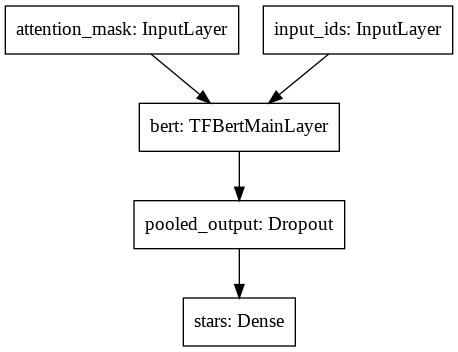

In [26]:
tf.keras.utils.plot_model(model_attention, to_file="bert_attention.jpg", show_shapes=False)

In [27]:
optimizer = RMSprop(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

model_attention.compile(
    optimizer = optimizer,
    loss = CategoricalCrossentropy(from_logits = True), 
    metrics = CategoricalAccuracy('accuracy'))

y_train = to_categorical(train_df["stars"]-1, num_classes=5)
y_valid = to_categorical(valid_df["stars"]-1, num_classes=5)

x_train_attention_mask = tokenizer(
    text=train_df["text"].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_valid_attention_mask = tokenizer(
    text=valid_df["text"].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

os.makedirs("models", exist_ok=True)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_bert_with_attention_mask.hdf5"),
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1)

history = model_attention.fit(
    x={'input_ids': x_train_attention_mask['input_ids'], 'attention_mask': x_train_attention_mask['attention_mask']},
    y={'stars': y_train},
    validation_split=0.2,
    batch_size=64,
    epochs=10,
    callbacks=[checkpointer, earlystopping])

Epoch 1/10
125/125 [==============================] - 343s 3s/step - loss: 1.2822 - accuracy: 0.4338 - val_loss: 0.9566 - val_accuracy: 0.6110

Epoch 00001: val_accuracy improved from -inf to 0.61100, saving model to models/weights_bert_with_attention_mask.hdf5
Epoch 2/10
125/125 [==============================] - 316s 3s/step - loss: 0.8725 - accuracy: 0.6330 - val_loss: 0.9659 - val_accuracy: 0.5925

Epoch 00002: val_accuracy did not improve from 0.61100
Epoch 3/10
125/125 [==============================] - 316s 3s/step - loss: 0.7283 - accuracy: 0.7027 - val_loss: 0.9708 - val_accuracy: 0.6140

Epoch 00003: val_accuracy improved from 0.61100 to 0.61400, saving model to models/weights_bert_with_attention_mask.hdf5
Epoch 4/10
125/125 [==============================] - 316s 3s/step - loss: 0.6049 - accuracy: 0.7702 - val_loss: 0.9967 - val_accuracy: 0.6125

Epoch 00004: val_accuracy did not improve from 0.61400
Epoch 00004: early stopping


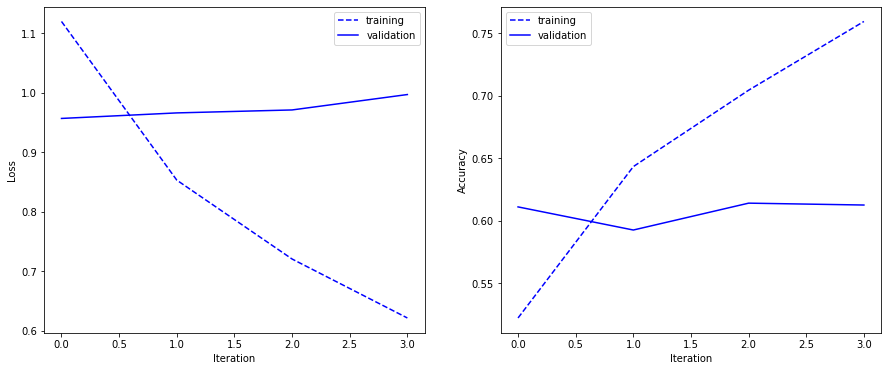

In [28]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(history.history["val_loss"], label="validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="training", color="blue", linestyle="dashed")
plt.plot(history.history["val_accuracy"], label="validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [29]:
model = keras.models.load_model(os.path.join("models", "weights_bert_with_attention_mask.hdf5"))

train_score = model.evaluate(
    x={'input_ids': x_train_attention_mask['input_ids'], 'attention_mask': x_train_attention_mask['attention_mask']},
    y={'stars': y_train})

valid_score = model.evaluate(
    x={'input_ids': x_valid_attention_mask['input_ids'], 'attention_mask': x_valid_attention_mask['attention_mask']},
    y={'stars': y_valid})

print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

63/63 [==============================] - 25s 402ms/step - loss: 0.9625 - accuracy: 0.6210
training loss: 0.6558575630187988 training accuracy 0.7494000196456909
valid loss: 0.9625034928321838 valid accuracy 0.6209999918937683
